<a href="https://colab.research.google.com/github/PaprikaSteiger/CNN_GAN_tensorflow_vs_pytorch/blob/master/cnngan_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a CNNGAN with pytroch

## 1. Import and Preprocessing
### a) Importing modules

In [730]:
# Load required packages - data handling & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Load required packages - deep learning 
import torch
import torch.nn as nn
import torch.optim as optim

In [731]:
print(f"tensorflow: {torch.__version__}")
import sys
print(f"python: {sys.version[:5]}")

tensorflow: 1.8.1+cu101
python: 3.7.1


### b) Importing the data

In [732]:
# I exceeded my git LFS bandwidth limit for this month, thus the file cannot be loaded from git
#train_data = pd.read_csv('https://media.githubusercontent.com/media/PaprikaSteiger/CNN_GAN_tensorflow_vs_pytorch/master/fashion-mnist_train.csv')

# load directly from keras and transform to pandas
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
y_train = y_train.reshape((-1,1))
x_train = x_train.reshape((-1, 28*28))
x_train = np.concatenate([y_train, x_train], axis=1)
labels = ["label"] + [f"pixel{i}" for i in range(1,785)]
train_data = pd.DataFrame(x_train,columns=labels, index=list(range(60000)))
del x_train
del y_train
del x_test
del y_test

# or load from git repo from mmeirer
#train_data = pd.read_csv('https://media.githubusercontent.com/media/mmeierer/CNN---TensorFlow-vs-PyTorch/main/fashion-mnist_train.csv')

In [733]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,41,188,103,54,48,43,87,168,133,16,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,49,136,219,216,...,244,240,243,214,224,162,0,2,0,0,0,0,0,0,0,0,0,1,0,0,139,146,130,135,135,137,125,124,125,121,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,22,118,24,0,0,0,0,0,48,88,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,100,212,...,106,102,75,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,18,42,57,56,32,8,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,96,175,156,64,14,54,137,204,194,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,186,177,183,175,...,83,152,85,160,133,100,12,0,0,0,0,0,0,0,0,0,0,0,4,0,2,0,35,4,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,189,206,187,...,255,242,255,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,102,168,25,0,139,161,74,0,0,0,0,0,0,0,0,0,0


In [734]:
train_images = train_data.iloc[:,1:]

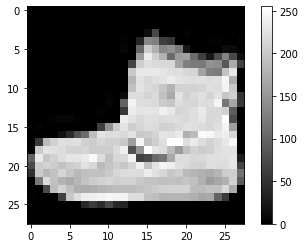

In [735]:
plt.figure()
plt.imshow(train_images.values[0].reshape(28,28), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c) Data preparation

In [736]:
# use maximum normalization
train_images = train_images / np.float32(255)

In [737]:
train_images.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,0.160784,0.737255,0.403922,0.211765,0.188235,0.168627,0.341176,0.658824,0.521569,0.062745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.192157,0.533333,0.858824,0.847059,0.894118,...,0.956863,0.941176,0.952941,0.839216,0.878431,0.635294,0.000000,0.007843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.000000,0.0,0.545098,0.572549,0.509804,0.529412,0.529412,0.537255,0.490196,0.486275,0.490196,0.474510,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,0.462745,0.094118,0.000000,0.000000,0.000000,0.000000,0.000000,0.188235,0.345098,0.019608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.047059,0.392157,0.831373,0.803922,...,0.415686,0.400000,0.294118,0.039216,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.003922,0.000000,0.000000,0.000000,0.070588,0.164706,0.223529,0.219608,0.125490,0.031373,0.000000,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,0.686275,0.611765,0.250980,0.054902,0.211765,0.537255,0.800000,0.760784,0.400000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.286275,0.729412,0.694118,0.717647,0.686275,0.737255,...,0.325490,0.596078,0.333333,0.627451,0.521569,0.392157,0.047059,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.015686,0.0,0.007843,0.000000,0.137255,0.015686,0.129412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101961,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.741176,0.807843,0.733333,0.125490,...,1.000000,0.949020,1.000000,0.274510,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.239216,0.400000,0.658824,0.098039,0.000000,0.545098,0.631373,0.290196,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0



## 2. Model specific data preparation (tensorflow)
## a) Load the data

In [738]:

x_train_pt = torch.from_numpy(train_images.values.reshape((-1, 1, 28, 28)))

### b) Tensor view of the data

In [739]:
x_train_pt.shape

torch.Size([60000, 1, 28, 28])

In [740]:
x_train_pt[0][0][5]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0235, 0.0000, 0.4000, 0.8000, 0.6902, 0.5255,
        0.5647, 0.4824, 0.0902, 0.0000, 0.0000, 0.0000, 0.0000, 0.0471, 0.0392,
        0.0000])

## 3. Model definition

In [741]:
# xavier_uniform_ is the default initialization of keras
def weights_init(m):
  classname = m.__class__.__name__
  if isinstance(m, nn.Linear):
      nn.init.uniform_(m.weight.data, -1,1)
      nn.init.zeros_(m.bias.data)
  if isinstance(m, nn.ConvTranspose2d):
      nn.init.xavier_uniform_(m.weight.data)
      nn.init.zeros_(m.bias.data)
  if isinstance(m, nn.Conv2d):
    nn.init.xavier_uniform_(m.weight.data)
    nn.init.zeros_(m.bias.data)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.normal_(m.weight.data, 1.0, 0.02)
      nn.init.constant_(m.bias.data, 0)

### a.1) Generator

In [742]:
def generator_model():
    model = nn.Sequential()
    model.add_module("Conv2D1", nn.ConvTranspose2d(100, 64, 7, stride=1, padding=0, bias=True))
    model.add_module("Batchnorm1", nn.BatchNorm2d(64))
    model.add_module("LeakyRelu1", nn.LeakyReLU(inplace=True))
    
    model.add_module("Conv2D2", nn.ConvTranspose2d(64, 32, (8,8), stride=(1,1), padding=0, bias=True))
    model.add_module("Batchnorm2", nn.BatchNorm2d(32))
    model.add_module("LeakyRelu2", nn.LeakyReLU(inplace=True))
    
    model.add_module("Conv2D3", nn.ConvTranspose2d(32, 1, (15,15), stride=1, padding=0, bias=True))
    model.add_module("Sigmoid1", nn.Sigmoid())
    return model
generator = generator_model()   

###  a.2) Inspect the generator model

In [743]:
print(generator)

Sequential(
  (Conv2D1): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1))
  (Batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01, inplace=True)
  (Conv2D2): ConvTranspose2d(64, 32, kernel_size=(8, 8), stride=(1, 1))
  (Batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu2): LeakyReLU(negative_slope=0.01, inplace=True)
  (Conv2D3): ConvTranspose2d(32, 1, kernel_size=(15, 15), stride=(1, 1))
  (Sigmoid1): Sigmoid()
)


In [744]:
generator.apply(weights_init)

Sequential(
  (Conv2D1): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1))
  (Batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01, inplace=True)
  (Conv2D2): ConvTranspose2d(64, 32, kernel_size=(8, 8), stride=(1, 1))
  (Batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu2): LeakyReLU(negative_slope=0.01, inplace=True)
  (Conv2D3): ConvTranspose2d(32, 1, kernel_size=(15, 15), stride=(1, 1))
  (Sigmoid1): Sigmoid()
)

In [745]:
# generated image not trained
fake_im_not_trained = generator(torch.normal(0, 1, size=[1, 100, 1, 1]))
# check output shape of generator
fake_im_not_trained.shape


torch.Size([1, 1, 28, 28])

### a.3) Inspect the first convolutional layer

In [746]:
generator[0].weight[0]

tensor([[[ 4.6424e-03,  1.0673e-02, -6.5383e-04,  ..., -1.8760e-02,
           8.8743e-03, -9.3986e-03],
         [-3.6481e-03,  2.5223e-02,  2.1929e-02,  ..., -2.4560e-02,
           2.1061e-02, -4.3437e-03],
         [-1.3387e-02, -2.0594e-02,  6.9096e-03,  ...,  9.1053e-03,
           9.2685e-03,  2.5996e-03],
         ...,
         [-2.2603e-02, -1.5000e-03, -1.7244e-02,  ..., -2.3265e-02,
           1.3061e-02, -1.4693e-02],
         [-2.3893e-02, -1.5705e-02, -5.7461e-04,  ...,  1.1707e-02,
          -5.5514e-03, -2.2158e-03],
         [ 1.4096e-02,  4.7616e-03,  2.2125e-02,  ...,  1.8149e-02,
          -2.2733e-02, -1.6839e-02]],

        [[ 7.6864e-03, -1.5831e-02,  7.0736e-03,  ..., -1.5897e-02,
           1.5183e-02,  1.9924e-02],
         [ 8.1973e-03,  2.2212e-02,  1.1774e-02,  ..., -1.5339e-02,
           1.5172e-02, -2.1657e-02],
         [ 6.2984e-03, -1.1018e-02,  1.0971e-02,  ..., -6.6268e-03,
          -3.0072e-03,  2.6143e-02],
         ...,
         [-1.2144e-02, -9

In [747]:
generator[0].weight.shape

torch.Size([100, 64, 7, 7])

In [748]:
generator[0].bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [749]:
generator[0].bias.shape

torch.Size([64])

### b.1) Discriminator

In [750]:
def discriminator_model():
    model = nn.Sequential()
    model.add_module("Conv2D1", nn.Conv2d(1, 2, kernel_size=5, stride=1, padding=2))
    model.add_module("Pooling1", nn.AvgPool2d(kernel_size=2, stride=2))
    model.add_module("LeakyRelu1", nn.LeakyReLU(0.2, inplace=True))
    model.add_module("Dropout1", nn.Dropout(0.3))
    
    model.add_module("Conv2D2", nn.Conv2d(2, 2, kernel_size=5, stride=1, padding=2))
    model.add_module("LeakyRelu2", nn.LeakyReLU(0.2, inplace=True))
    
    model.add_module("Conv2D3", nn.Conv2d(2, 1, kernel_size=5, stride=1, padding=0))
    model.add_module("LeakyRelu3", nn.LeakyReLU(0.2, inplace=True))
    
    model.add_module("Flatten1", nn.Flatten())
    
    model.add_module("Dense1", nn.Linear(100,100))
    model.add_module("LeakyRelu4", nn.LeakyReLU(0.2, inplace=True))
    
    model.add_module("Dense2", nn.Linear(100,64))
    model.add_module("Tanh", nn.Tanh())
    
    model.add_module("Dense3", nn.Linear(64,1))
    model.add_module("Sigmoid", nn.Sigmoid())
    return model
discriminator = discriminator_model()

### b.2) Inspect the discriminator model

In [751]:
print(discriminator)
discriminator(fake_im_not_trained).shape

Sequential(
  (Conv2D1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (LeakyRelu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Conv2D2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (Conv2D3): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1))
  (LeakyRelu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (Flatten1): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=100, out_features=100, bias=True)
  (LeakyRelu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (Dense2): Linear(in_features=100, out_features=64, bias=True)
  (Tanh): Tanh()
  (Dense3): Linear(in_features=64, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)


torch.Size([1, 1])

In [752]:
discriminator.apply(weights_init)

Sequential(
  (Conv2D1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (LeakyRelu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Conv2D2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (Conv2D3): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1))
  (LeakyRelu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (Flatten1): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=100, out_features=100, bias=True)
  (LeakyRelu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (Dense2): Linear(in_features=100, out_features=64, bias=True)
  (Tanh): Tanh()
  (Dense3): Linear(in_features=64, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)

### b.3) Inspect the first convolutional layer

In [753]:
discriminator[0].weight[0]

tensor([[[ 0.2220, -0.1318, -0.2048, -0.1819, -0.0909],
         [ 0.2374,  0.1341, -0.0209,  0.1216, -0.2292],
         [-0.0693,  0.1822, -0.2262, -0.1267, -0.2334],
         [ 0.1592, -0.1484, -0.2487, -0.2118,  0.0418],
         [ 0.2331, -0.2714,  0.1778,  0.1471, -0.0151]]],
       grad_fn=<SelectBackward>)

In [754]:
discriminator[0].weight.shape

torch.Size([2, 1, 5, 5])

In [755]:
discriminator[0].bias

Parameter containing:
tensor([0., 0.], requires_grad=True)

In [756]:
discriminator[0].bias.shape

torch.Size([2])

## 4. Loss & Optimizer

### 4.a) Generator loss

In [757]:
cross_entropy = nn.BCEWithLogitsLoss()
def generator_loss(fake_output):
    return cross_entropy(torch.ones_like(fake_output), fake_output)

### 4.b) Discriminator loss

In [758]:
def real_discriminator_loss(real_output):
    return  cross_entropy(torch.ones_like(real_output), real_output)

def fake_discriminator_loss(fake_output):
    return cross_entropy(torch.zeros_like(fake_output), fake_output)

## 4.c) Optimizers

In [767]:
generator_optimizer = optim.Adam(generator.parameters(), lr=1e-3)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)

def correct_classification(y_true, y_prob):
    assert y_true.size() == y_prob.size()
    y_prob = (y_prob > 0.5).float()
    return (y_true == y_prob).sum().item()

[Parameter containing:
tensor([[[[ 4.6424e-03,  1.0673e-02, -6.5383e-04,  ..., -1.8760e-02,
            8.8743e-03, -9.3986e-03],
          [-3.6481e-03,  2.5223e-02,  2.1929e-02,  ..., -2.4560e-02,
            2.1061e-02, -4.3437e-03],
          [-1.3387e-02, -2.0594e-02,  6.9096e-03,  ...,  9.1053e-03,
            9.2685e-03,  2.5996e-03],
          ...,
          [-2.2603e-02, -1.5000e-03, -1.7244e-02,  ..., -2.3265e-02,
            1.3061e-02, -1.4693e-02],
          [-2.3893e-02, -1.5705e-02, -5.7461e-04,  ...,  1.1707e-02,
           -5.5514e-03, -2.2158e-03],
          [ 1.4096e-02,  4.7616e-03,  2.2125e-02,  ...,  1.8149e-02,
           -2.2733e-02, -1.6839e-02]],

         [[ 7.6864e-03, -1.5831e-02,  7.0736e-03,  ..., -1.5897e-02,
            1.5183e-02,  1.9924e-02],
          [ 8.1973e-03,  2.2212e-02,  1.1774e-02,  ..., -1.5339e-02,
            1.5172e-02, -2.1657e-02],
          [ 6.2984e-03, -1.1018e-02,  1.0971e-02,  ..., -6.6268e-03,
           -3.0072e-03,  2.6143e-02

## 5. Training

In [760]:
def train_step_pt(generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size = 100):
    gen_loss_tot = []
    disc_loss_tot = []
    disc_acc_real_tot = 0
    disc_acc_fake_tot = 0
    generator.train()
    discriminator.train()
    for beg_i in range(0, x_train_pt.shape[0], batch_size):
        x_train_batch_pt = x_train_pt[beg_i:beg_i + batch_size]

        x_fake_batch_pt = torch.normal(0, 1, size=[batch_size, 100, 1, 1])
        
        discriminator_optimizer.zero_grad()
        real_output = discriminator(x_train_batch_pt.float()).view(-1)
        disc_loss_real = real_discriminator_loss(real_output)
        disc_loss_real.backward()
        
        generated_images = generator(x_fake_batch_pt)
        fake_output = discriminator(generated_images.detach()).view(-1)
        disc_loss_fake = fake_discriminator_loss(fake_output)
        disc_loss_fake.backward()
        err = disc_loss_fake + disc_loss_real
        discriminator_optimizer.step()
        # optimize generator
        generator_optimizer.zero_grad()
        fake_output = discriminator(generated_images.detach()).view(-1)
        gen_loss = generator_loss(fake_output)
        gen_loss.backward()
        generator_optimizer.step()
        
        gen_loss_tot.append(gen_loss.mean().item())
        disc_loss_tot.append(err.mean().item())
        disc_acc_real_tot += correct_classification(torch.ones_like(real_output), real_output)
        disc_acc_fake_tot += correct_classification(torch.zeros_like(fake_output), fake_output)

    disc_acc_real_tot = disc_acc_real_tot/x_train_pt.size(0)
    disc_acc_fake_tot = disc_acc_fake_tot/x_train_pt.size(0)
    disc_acc_tot = np.mean([disc_acc_real_tot, disc_acc_fake_tot])
    return gen_loss_tot, disc_loss_tot, disc_acc_tot

In [761]:
train_losses_generator_pt = []
train_losses_discriminator_pt = []
train_acc_discriminator_pt = []
epochs = 15
start = time.time()
for epoch in range(epochs):
    gen_loss, disc_loss, disc_acc = train_step_pt(generator, discriminator, generator_optimizer, discriminator_optimizer)
    gen_loss = np.mean(gen_loss)
    disc_loss = np.mean(disc_loss)
    train_losses_generator_pt.append(gen_loss)
    train_losses_discriminator_pt.append(disc_loss)
    train_acc_discriminator_pt.append(disc_acc*100)


    template = ("Epoch {}, Loss_Generator: {}, Loss_Discriminator: {}, Discriminator_Accuracy: {}")
    print(template.format(epoch+1, gen_loss, disc_loss, disc_acc*100))
end = time.time()
print(f"Total training time{(end - start)/60.0}")

Epoch 1, Loss_Generator: 0.31378566736976304, Loss_Discriminator: 1.0084742067257564, Discriminator_Accuracy: 49.93666666666666
Epoch 2, Loss_Generator: 0.3132629880309105, Loss_Discriminator: 1.0064116011063258, Discriminator_Accuracy: 50.0
Epoch 3, Loss_Generator: 0.313262494156758, Loss_Discriminator: 1.006410505771637, Discriminator_Accuracy: 50.0
Epoch 4, Loss_Generator: 0.31326221535603205, Loss_Discriminator: 1.0064095383882523, Discriminator_Accuracy: 50.0
Epoch 5, Loss_Generator: 0.31326206515232724, Loss_Discriminator: 1.006409325202306, Discriminator_Accuracy: 50.0
Epoch 6, Loss_Generator: 0.3132619564731916, Loss_Discriminator: 1.0064091116189957, Discriminator_Accuracy: 50.0
Epoch 7, Loss_Generator: 0.31326188360651336, Loss_Discriminator: 1.0064090277751288, Discriminator_Accuracy: 50.0
Epoch 8, Loss_Generator: 0.3132618357737859, Loss_Discriminator: 1.0064089743296305, Discriminator_Accuracy: 50.0
Epoch 9, Loss_Generator: 0.3132617874443531, Loss_Discriminator: 1.0064089

In [762]:
print(f"Total training time{(end - start)/60.0}")

Total training time26.637792420387267


### b) Training progress

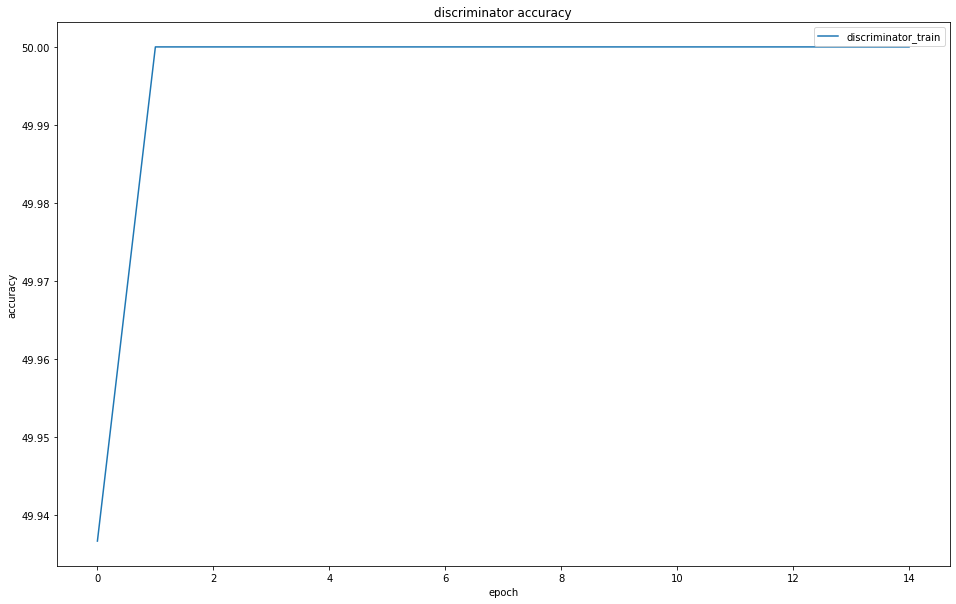

In [763]:
plt.figure(figsize=(16,10))
plt.plot(train_acc_discriminator_pt)
plt.title('discriminator accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['discriminator_train'], loc='upper right')
plt.show()

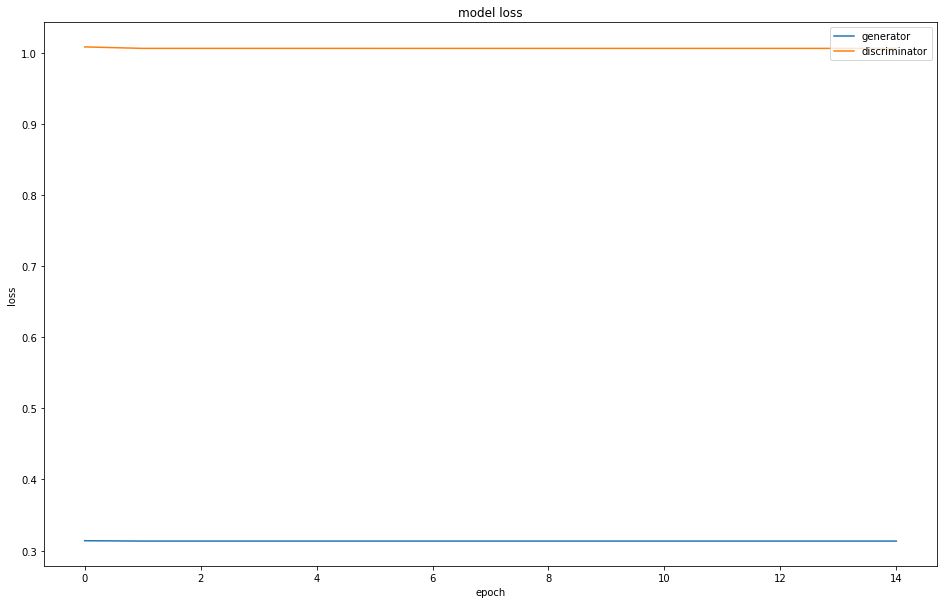

In [764]:
plt.figure(figsize=(16,10))
plt.plot(train_losses_generator_pt)
plt.plot(train_losses_discriminator_pt)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper right')
plt.show()

### c1) Generator output before training

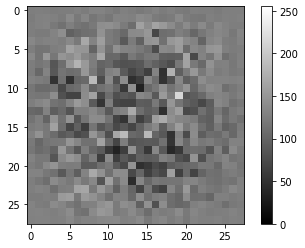

In [765]:

fake_im_not_trained = fake_im_not_trained.detach().numpy() * 255
fake_im_not_trained = fake_im_not_trained.reshape((28,28))
plt.figure()
plt.imshow(fake_im_not_trained, cmap='gray')
plt.clim(0, 255)
plt.colorbar()
plt.grid(False)
plt.show()

### c2) Generator output after training

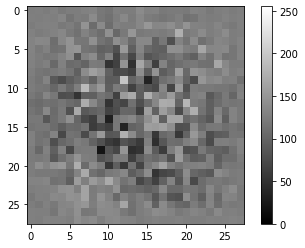

In [766]:
seed2 = torch.normal(0, 1, size=[1, 100, 1, 1])
generator.train(False)
fake_im = generator(seed2)
fake_im = fake_im.detach().numpy() * 255
fake_im = fake_im.reshape((28,28))
plt.figure()
plt.imshow(fake_im, cmap='gray')
plt.clim(0, 255)
plt.colorbar()
plt.grid(False)
plt.show()

## 6. References
The presented model is based on a combination of two tutorials for deep cnn-gans:
1) https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

2) https://www.tensorflow.org/tutorials/generative/dcgan